<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import os
%matplotlib inline
import pylab as pl
import scipy.optimize as opt

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-03-06 14:24:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-03-06 14:24:58 (12.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [30]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



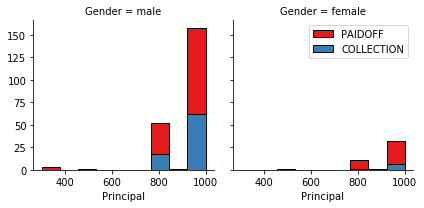

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

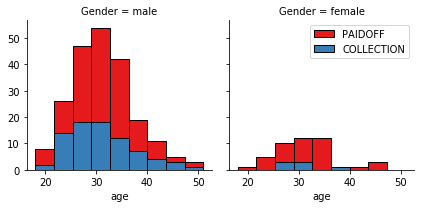

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

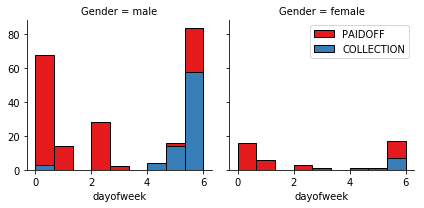

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,Bechalor,High School or Below,college
0,1000,30,45,0,0,1,0
1,1000,30,33,1,1,0,0
2,1000,15,27,0,0,0,1
3,1000,30,28,1,0,0,1
4,1000,30,29,0,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,Bechalor,High School or Below,college
0,1000,30,45,0,0,1,0
1,1000,30,33,1,1,0,0
2,1000,15,27,0,0,0,1
3,1000,30,28,1,0,0,1
4,1000,30,29,0,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [94]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -0.38170062,
         1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177,  2.61985426,
        -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -0.38170062,
        -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177, -0.38170062,
        -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004, -0.38170062,
        -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [95]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 7) (276,)
Test set: (70, 7) (70,)


In [96]:
from sklearn.neighbors import KNeighborsClassifier

k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [97]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

TESTING

In [98]:
yhat = neigh.predict(X_test)
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [25]:
yhat_prob = neigh.predict_proba(X_test)
yhat_prob

array([[0.25, 0.75],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [1.  , 0.  ],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [1.  , 0.  ],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.25, 0.75],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.  , 1.  ],
       [0.75, 0.25],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.  , 1.  ],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.  , 1.  ],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.5 , 0.5 ],
       [0.  , 1.  ],
       [0.25, 0.75],
       [0.5 , 0.5 ],
       [0.  , 1.  ],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.  ,

In [26]:
from sklearn import metrics

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7463768115942029
Test set Accuracy:  0.6714285714285714


In [99]:
k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))

Train set Accuracy:  0.7681159420289855
Test set Accuracy:  0.7285714285714285


In [28]:
from sklearn.neighbors import KNeighborsClassifier

import sklearn.metrics as metrics

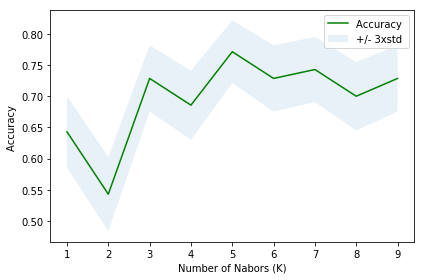

Best accuracy: 0.7714285714285715 k= 5


In [100]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

ConfustionMx = [];
for n in range(1,Ks):
    
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "Best accuracy:", mean_acc.max(), "k=", mean_acc.argmax()+1)

In [101]:
seed = 50
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.40, random_state=seed)



In [102]:
score=[]
for k in range(1,100):
    knn=KNeighborsClassifier(n_neighbors=k,weights='uniform')
    knn.fit(X_train,y_train)
    predKNN=knn.predict(X_test)
    accuracy=metrics.accuracy_score(predKNN,y_test)
    score.append(accuracy*100)
    print (k,': ',accuracy)

1 :  0.6187050359712231
2 :  0.4172661870503597
3 :  0.60431654676259
4 :  0.5971223021582733
5 :  0.7482014388489209
6 :  0.6906474820143885
7 :  0.7841726618705036
8 :  0.7697841726618705
9 :  0.8057553956834532
10 :  0.762589928057554
11 :  0.8129496402877698
12 :  0.762589928057554
13 :  0.8201438848920863
14 :  0.762589928057554
15 :  0.7913669064748201
16 :  0.7913669064748201
17 :  0.7913669064748201
18 :  0.7841726618705036
19 :  0.8129496402877698
20 :  0.7913669064748201
21 :  0.8201438848920863
22 :  0.8129496402877698
23 :  0.8201438848920863
24 :  0.8201438848920863
25 :  0.8201438848920863
26 :  0.8201438848920863
27 :  0.8201438848920863
28 :  0.8201438848920863
29 :  0.8201438848920863
30 :  0.8201438848920863
31 :  0.8201438848920863
32 :  0.8201438848920863
33 :  0.8201438848920863
34 :  0.8201438848920863
35 :  0.8201438848920863
36 :  0.8201438848920863
37 :  0.8201438848920863
38 :  0.8201438848920863
39 :  0.8201438848920863
40 :  0.8201438848920863
41 :  0.820143

In [103]:
print('highest accuracy value is at index =', score.index(max(score))+1,' accuracy score = ',round(max(score),2),'%')

highest accuracy value is at index = 13  accuracy score =  82.01 %


Text(0, 0.5, 'Train Accuracy')

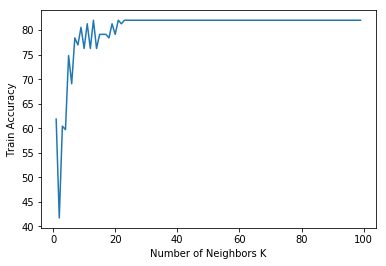

In [104]:
plt.plot(range(1,100),score)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')

In [33]:
knn=KNeighborsClassifier(n_neighbors=41,weights='uniform')
knn.fit(X_train,y_train)
predKNN=knn.predict(X_test)
accuracy=metrics.accuracy_score(predKNN,y_test)
print("accuracy : ",round(accuracy,3)*100,'%')

accuracy :  82.0 %


In [37]:
from ipykernel import kernelapp as app

In [38]:
from sklearn.metrics import classification_report,jaccard_similarity_score,log_loss,f1_score
print(classification_report(y_test,predKNN))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,predKNN)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,predKNN,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, knn.predict(X_train))*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        25
     PAIDOFF       0.82      1.00      0.90       114

   micro avg       0.82      0.82      0.82       139
   macro avg       0.41      0.50      0.45       139
weighted avg       0.67      0.82      0.74       139



Jaccard Similarity Score :  82.01 %


F1-SCORE :  [0.         0.90118577]


Train Accuracy:  70.53140096618358 %


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

In [146]:
!conda update -n base -c defaults conda

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs: 
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.42.1                |             py_0          56 KB
    conda-4.8.2                |           py37_0         3.0 MB
    conda-package-handling-1.6.0|   py37h7b6447c_0         872 KB
    openssl-1.1.1d             |       h7b6447c_4         3.7 MB
    ------------------------------------------------------------
                                           Total:         7.7 MB

The following NEW packages will be INSTALLED:

    conda-package-handling: 1.6.0-py37h7b6447c_0
    tqdm:                   4.42.1-py_0         

The following packages will be UPDATED:

    conda:                  4.5.12-py37_0        --> 4.8.2-py37_0     
    openssl:                1.1.1d-h7b6447c_3    --> 1.1.1d-h7b6447c_4


tqdm-4.42.

# Decision Tree

In [147]:
!conda install -c anaconda seaborn -y


Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::blaze==0.11.3=py36_0
  - defaults/linux-64::numba==0.42.0=py36h962f231_0
done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tbb-2020.0                 |       hfd86e86_0         1.4 MB  anaconda
    ------------------------------------------------------------
                                           Total:         1.4 MB

The following NEW packages will be INSTALLED:

  tbb                anaconda/linux-64::tbb-2020.0-hfd86e86_0



tbb-2020.0           | 1.4 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [149]:
!conda install -c anaconda sklearn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - sklearn

Current channels:

  - https://conda.anaconda.org/anaconda/linux-64
  - https://conda.anaconda.org/anaconda/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [157]:
from sklearn.tree import DecisionTreeClassifier

Tree=DecisionTreeClassifier()

In [164]:
Tree=DecisionTreeClassifier(max_depth=6,criterion='entropy')
Tree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [165]:
Tree.fit(X_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [166]:
predTree=Tree.predict(X_test)
print(predTree [0:5])
print(y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [205]:
print(classification_report(y_test,predTree))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,predTree)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,predTree,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, Tree.predict(X_train))*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.20      0.07      0.10        15
     PAIDOFF       0.78      0.93      0.85        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.49      0.50      0.48        70
weighted avg       0.66      0.74      0.69        70



Jaccard Similarity Score :  74.29 %


F1-SCORE :  [0.1  0.85]


Train Accuracy:  75.72463768115942 %


In [67]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [169]:
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

Decision Trees's Accuracy:  0.7428571428571429


In [170]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, predTree)

0.7428571428571429

In [177]:
!conda update -n base -c defaults conda



Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         125 KB
    chardet-3.0.4              |        py37_1003         174 KB
    libstdcxx-ng-9.1.0         |       hdf63c60_0         3.1 MB
    ncurses-6.2                |       he6710b0_0         1.1 MB
    pycosat-0.6.3              |   py37h7b6447c_0          82 KB
    pycparser-2.19             |           py37_0         171 KB
    pysocks-1.7.1              |           py37_0          31 KB
    requests-2.22.0            |           py37_1          92 KB
    ruamel_yaml-0.15.87        |   py37h7b6447c_0         256 KB
    urllib3-1.25.8             |           py37_0         169 KB
    ------------------------------------------------------------
                   

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/chardet-3.0.4-py37_1003/lib/python3.7/site-packages/chardet/sbcharsetprober.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/chardet-3.0.4-py37_1003/lib/python3.7/site-packages/chardet/jisfreq.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/chardet-3.0.4-py37_1003/lib/python3.7/site-packages/chardet/universaldetector.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/chardet-3.0.4-py37_1003/lib/python3.7/site-packages/chardet/chardistribution.py.  Plea

urllib3-1.25.8       | 169 KB    | ##################################### | 100% 
ca-certificates-2020 | 125 KB    | ##################################### | 100% 
libstdcxx-ng-9.1.0   | 3.1 MB    | ##################################### | 100% 
ruamel_yaml-0.15.87  | 256 KB    | ##################################### | 100% 
requests-2.22.0      | 92 KB     | ##################################### | 100% 
pycparser-2.19       | 171 KB    | ##################################### | 100% 
pysocks-1.7.1        | 31 KB     | ##################################### | 100% 
pycosat-0.6.3        | 82 KB     | ##################################### | 100% 

InvalidArchiveError('Error with archive /opt/conda/pkgs/chardet-3.0.4-py37_1003f4gp916n/info-chardet-3.0.4-py37_1003.tar.zst.  You probably need to delete and re-download or re-create this file.  Message from libarchive was:\n\nCould not unlink')



ModuleNotFoundError: No module named 'pydotplus'

In [178]:
 !conda install -c conda-forge pydotplus -y
    
 !conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-pyhd1c1de3_3

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-ce

In [179]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

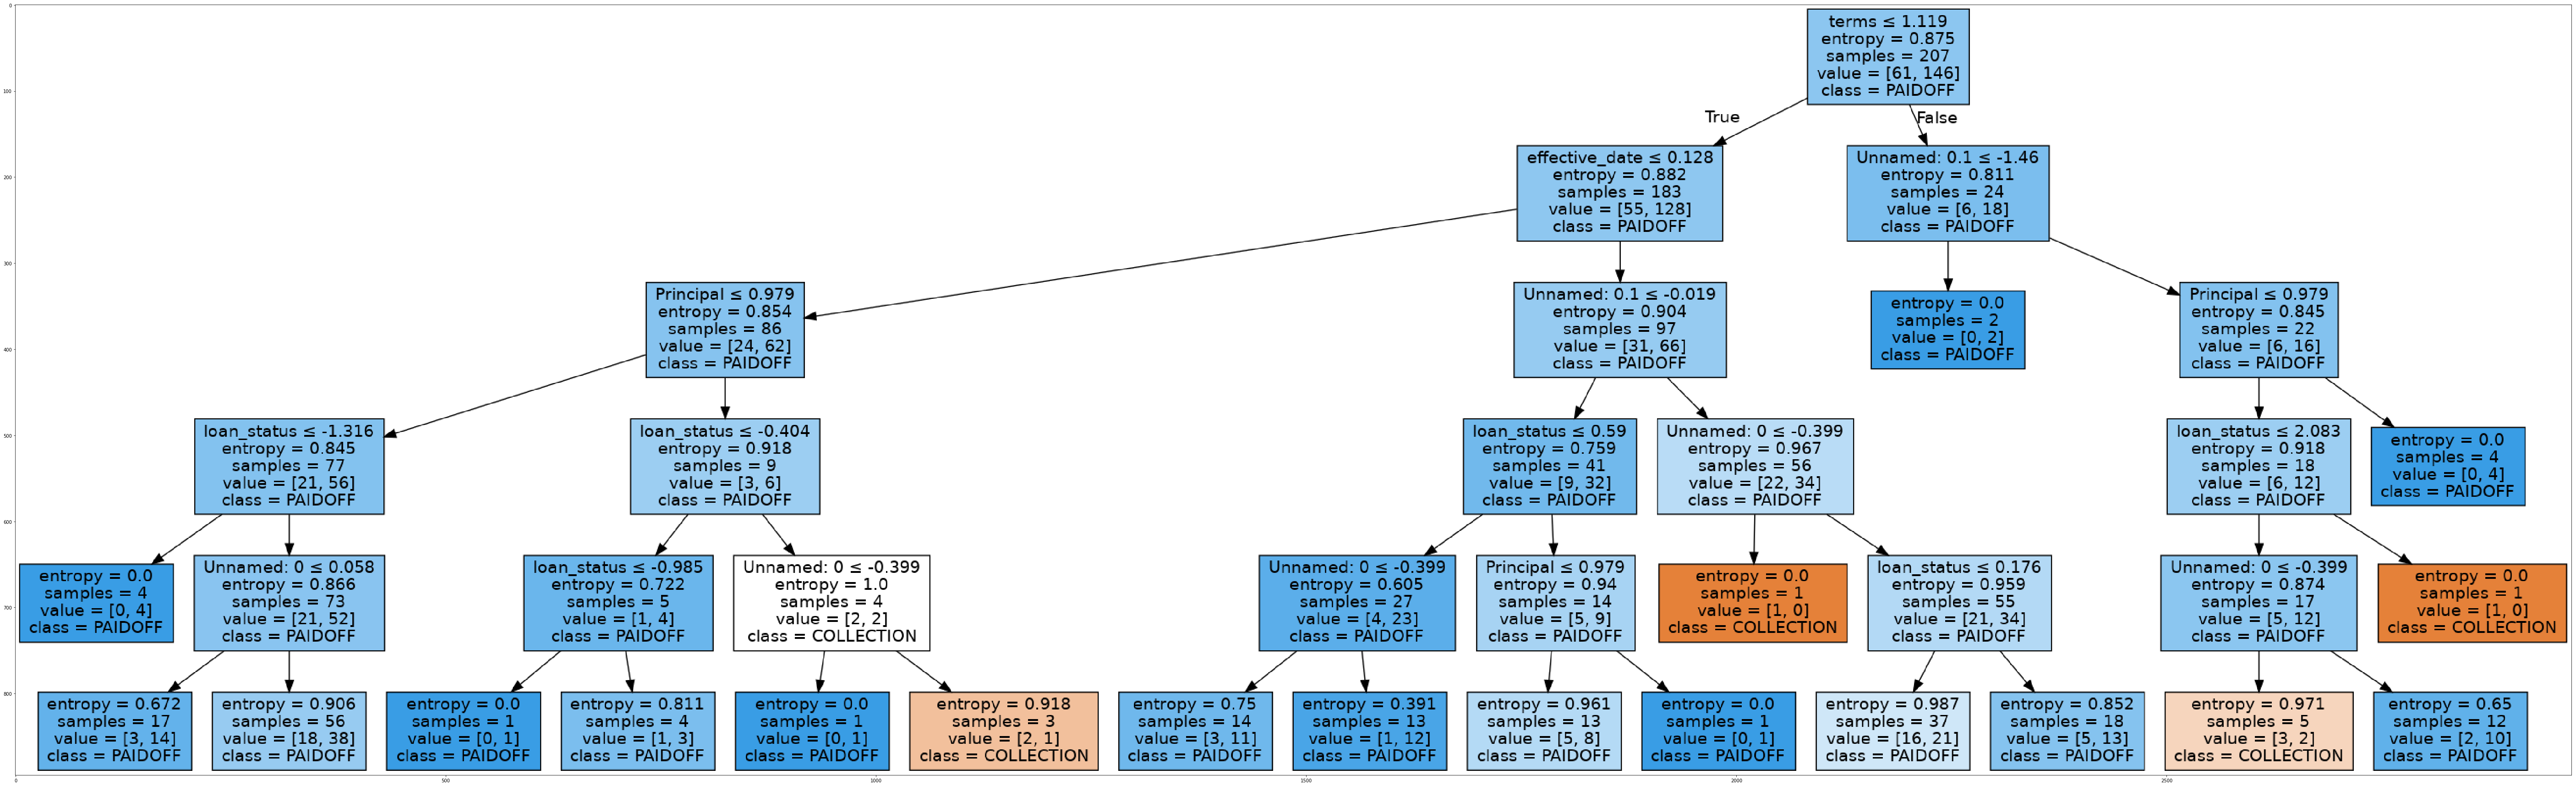

In [186]:
dot_data = StringIO()
filename = "loan_tree"
featureNames = df.columns[0:7]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(Tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [214]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender', 'dayofweek',
       'weekend'],
      dtype='object')

In [105]:
df.dtypes
df = df[pd.to_numeric(df['education'], errors='coerce').notnull()]
df['education'] = df['education'].astype('int')
df.dtypes

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [106]:
yhat = clf.predict(X_test)
yhat [0:5]
from sklearn.metrics import classification_report, confusion_matrix
import itertools

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        25
     PAIDOFF       0.82      1.00      0.90       114

   micro avg       0.82      0.82      0.82       139
   macro avg       0.41      0.50      0.45       139
weighted avg       0.67      0.82      0.74       139



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

0.8201438848920863

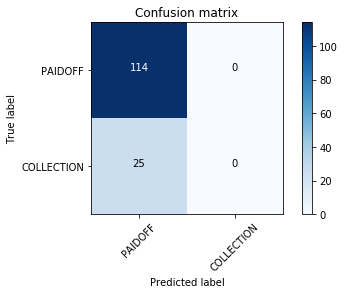

In [107]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

# Logistic Regression

In [110]:
df = df[['loan_status', 'Principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'Gender']]
df['loan_status'] = df['loan_status'].astype('int')

from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LogR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LogR

Train set: (276, 7) (276,)
Test set: (70, 7) (70,)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [111]:
yhat = LogR.predict(X_test)
yhat
yhat_prob = LogR.predict_proba(X_test)
yhat_prob

array([[0.43, 0.57],
       [0.38, 0.62],
       [0.4 , 0.6 ],
       [0.45, 0.55],
       [0.42, 0.58],
       [0.41, 0.59],
       [0.42, 0.58],
       [0.41, 0.59],
       [0.45, 0.55],
       [0.43, 0.57],
       [0.44, 0.56],
       [0.43, 0.57],
       [0.32, 0.68],
       [0.44, 0.56],
       [0.37, 0.63],
       [0.34, 0.66],
       [0.46, 0.54],
       [0.4 , 0.6 ],
       [0.44, 0.56],
       [0.42, 0.58],
       [0.37, 0.63],
       [0.43, 0.57],
       [0.45, 0.55],
       [0.39, 0.61],
       [0.33, 0.67],
       [0.44, 0.56],
       [0.44, 0.56],
       [0.3 , 0.7 ],
       [0.44, 0.56],
       [0.33, 0.67],
       [0.4 , 0.6 ],
       [0.39, 0.61],
       [0.39, 0.61],
       [0.42, 0.58],
       [0.31, 0.69],
       [0.39, 0.61],
       [0.44, 0.56],
       [0.38, 0.62],
       [0.38, 0.62],
       [0.39, 0.61],
       [0.44, 0.56],
       [0.42, 0.58],
       [0.38, 0.62],
       [0.44, 0.56],
       [0.4 , 0.6 ],
       [0.43, 0.57],
       [0.4 , 0.6 ],
       [0.43,

In [113]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7857142857142857

In [114]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [115]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.600866678869581

In [116]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob2))

LogLoss: : 0.53


# Model Evaluation using Test set

In [132]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

<h3> <bold>Load Test set for evaluation</bold></h3>

In [133]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-03-06 15:58:13--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-03-06 15:58:13 (360 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [134]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [135]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]
Y = test_df['loan_status'].values
Y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [196]:
yhatKNN=neigh.predict(X)
KNNJaccard = jaccard_similarity_score(y, yhatKNN)
KNNF1 = f1_score(y, yhatKNN, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("KNN LogLoss: : %.2f" % Logloss)
print("KNN Avg F1-score: %.2f" % KNNF1 )
print("KNN Jaccard Score: %.2f" % KNNJaccard)

KNN LogLoss: : 0.61
KNN Avg F1-score: 0.69
KNN Jaccard Score: 0.75


In [195]:
yhatDEC = Tree.predict(X)
DTJaccard = jaccard_similarity_score(y, yhatDEC)
DTF1 = f1_score(y, yhatDEC, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("Decision Tree LogLoss: : %.2f" % Logloss)
print("Decision Tree Avg F1-score: %.2f" % DTF1 )
print("Decision Tree Jaccard Score: %.2f" % DTJaccard)

Decision Tree LogLoss: : 0.61
Decision Tree Avg F1-score: 0.70
Decision Tree Jaccard Score: 0.75


In [197]:
yhatSVM=clf.predict(X)
SVMJaccard = jaccard_similarity_score(y, yhatSVM)
SVMF1 = f1_score(y, yhatSVM, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("SVM LogLoss: : %.2f" % Logloss)
print("SVM Avg F1-score: %.2f" % SVMF1)
print("SVM Jaccard score: %.2f" % SVMJaccard)


SVM LogLoss: : 0.61
SVM Avg F1-score: 0.64
SVM Jaccard score: 0.75


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [189]:
yhatLOG = LogR.predict(X)
yhatLOGproba = LogR.predict_proba(X)
LogRJaccard = jaccard_similarity_score(y, yhatLOG)
LogRF1 = f1_score(y, yhatLOG, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("LOG LogLoss: : %.2f" % Logloss)
print("LOG Avg F1-score: %.4f" % LogRF1)
print("LOG Jaccard score: %.4f" % LogRJaccard)


LOG LogLoss: : 0.61
LOG Avg F1-score: 0.6448
LOG Jaccard score: 0.7514


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [194]:
yhatKNN=neigh.predict(X)
KNNJaccard = jaccard_similarity_score(y, yhatKNN)
KNNF1 = f1_score(y, yhatKNN, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("KNN LogLoss: : %.2f" % Logloss)
print("KNN Avg F1-score: %.2f" % KNNF1 )
print("KNN Jaccard Score: %.2f" % KNNJaccard)

yhatDEC = Tree.predict(X)
DTJaccard = jaccard_similarity_score(y, yhatDEC)
DTF1 = f1_score(y, yhatDEC, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("Decision Tree LogLoss: : %.2f" % Logloss)
print("Avg F1-score: %.2f" % DTF1 )
print("Decision Tree Jaccard Score: %.2f" % DTJaccard)


yhatSVM=clf.predict(X)
SVMJaccard = jaccard_similarity_score(y, yhatSVM)
SVMF1 = f1_score(y, yhatSVM, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("SVM LogLoss: : %.2f" % Logloss)
print("SVM Avg F1-score: %.2f" % SVMF1)
print("SVM Jaccard score: %.2f" % SVMJaccard)


yhatLOG = LogR.predict(X)
yhatLOGproba = LogR.predict_proba(X)
LogRJaccard = jaccard_similarity_score(y, yhatLOG)
LogRF1 = f1_score(y, yhatLOG, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("LogLoss: : %.2f" % Logloss)
print("Avg F1-score: %.4f" % LogRF1)
print("LOG Jaccard score: %.4f" % LogRJaccard)

KNN LogLoss: : 0.61
KNN Avg F1-score: 0.69
KNN Jaccard Score: 0.75
Decision Tree LogLoss: : 0.61
Avg F1-score: 0.70
Decision Tree Jaccard Score: 0.75
SVM LogLoss: : 0.61
SVM Avg F1-score: 0.64
SVM Jaccard score: 0.75
LogLoss: : 0.61
Avg F1-score: 0.6448
LOG Jaccard score: 0.7514


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [201]:
Algoritm=['KNN','Decision Tree','SVM','LogisticRegression']
j_knn=round(jaccard_similarity_score(y, yhatKNN)*100,2)
j_dtree=round(jaccard_similarity_score(y, yhatDEC)*100,2)
j_svm=round(jaccard_similarity_score(y, yhatSVM)*100,2)
j_lgm=round(jaccard_similarity_score(y, yhatLOG)*100,2)
Jaccard=[j_knn,j_dtree,j_svm,j_lgm]

f1_knn=f1_score(y, yhatKNN,average=None)
f1_dtree=f1_score(y, yhatDEC,average=None)
f1_svm=f1_score(y, yhatSVM,average=None)
f1_lgm=f1_score(y, yhatLOG,average=None)
F1_score=[f1_knn,f1_dtree,f1_svm,f1_lgm]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [202]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,jaccard_similarity_score,log_loss,f1_score

In [203]:
table = pd.DataFrame({
    "Algorithm": Algoritm,
    "Jaccatd": Jaccard,
    "F1-Score": F1_score,
    "LogLoss":[np.NAN,np.NAN,np.NAN,np.NAN]
})

In [204]:
table

,Algorithm,Jaccatd,F1-Score,LogLoss
0,KNN,75.43,"[0.205607476635514, 0.8547008547008548]",NaN
1,Decision Tree,75.43,"[0.24778761061946908, 0.8531951640759932]",NaN
2,SVM,75.14,"[0.0, 0.858085808580858]",NaN
3,LogisticRegression,75.14,"[0.0, 0.858085808580858]",NaN


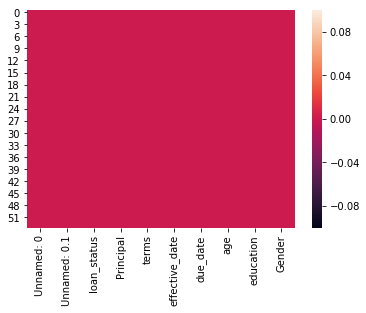

In [122]:
sns.heatmap(test_df.isnull())

In [48]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [49]:
dumm=pd.get_dummies(test_df['education'])
#dumm=dumm.drop('Master or Above',axis=1,inplace=True)
dumm=dumm[['Bechalor','High School or Below','college']]

In [50]:
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,dumm], axis=1)
#test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [51]:
test_data= test_feature
test_data= preprocessing.StandardScaler().fit(test_data).transform(test_data)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [55]:
y_t=test_df['loan_status']
y_t



0        PAIDOFF
1        PAIDOFF
2        PAIDOFF
3        PAIDOFF
4        PAIDOFF
5        PAIDOFF
6        PAIDOFF
7        PAIDOFF
8        PAIDOFF
9        PAIDOFF
10       PAIDOFF
11       PAIDOFF
12       PAIDOFF
13       PAIDOFF
14       PAIDOFF
15       PAIDOFF
16       PAIDOFF
17       PAIDOFF
18       PAIDOFF
19       PAIDOFF
20       PAIDOFF
21       PAIDOFF
22       PAIDOFF
23       PAIDOFF
24       PAIDOFF
25       PAIDOFF
26       PAIDOFF
27       PAIDOFF
28       PAIDOFF
29       PAIDOFF
30       PAIDOFF
31       PAIDOFF
32       PAIDOFF
33       PAIDOFF
34       PAIDOFF
35       PAIDOFF
36       PAIDOFF
37       PAIDOFF
38       PAIDOFF
39       PAIDOFF
40    COLLECTION
41    COLLECTION
42    COLLECTION
43    COLLECTION
44    COLLECTION
45    COLLECTION
46    COLLECTION
47    COLLECTION
48    COLLECTION
49    COLLECTION
50    COLLECTION
51    COLLECTION
52    COLLECTION
53    COLLECTION
Name: loan_status, dtype: object

<h3><bold>KNN</bold></h3>

In [53]:
knn=KNeighborsClassifier(n_neighbors=41,weights='uniform')
knn.fit(X_train,y_train)
predKNN=knn.predict(X_test)
accuracy=metrics.accuracy_score(predKNN,y_test)
print("accuracy : ",round(accuracy,3)*100,'%')


accuracy :  82.0 %


<h3><bold>BEST K FOR TEST DATA</bold></h3>

In [349]:
score=[]
for k in range(1,100):
    knn=KNeighborsClassifier(n_neighbors=k,weights='uniform')
    knn.fit(X_train,y_train)
    predKNN=knn.predict(X_test)
    accuracy=metrics.accuracy_score(predKNN,y_test)
    score.append(accuracy*100)
    print (k,': ',accuracy)

1 :  0.6428571428571429
2 :  0.5428571428571428
3 :  0.7285714285714285
4 :  0.6857142857142857
5 :  0.7714285714285715
6 :  0.7285714285714285
7 :  0.7428571428571429
8 :  0.7
9 :  0.7285714285714285
10 :  0.7428571428571429
11 :  0.7571428571428571
12 :  0.7428571428571429
13 :  0.8
14 :  0.8
15 :  0.8
16 :  0.8
17 :  0.7857142857142857
18 :  0.7857142857142857
19 :  0.7857142857142857
20 :  0.7857142857142857
21 :  0.7857142857142857
22 :  0.7857142857142857
23 :  0.7857142857142857
24 :  0.7857142857142857
25 :  0.7857142857142857
26 :  0.7857142857142857
27 :  0.7857142857142857
28 :  0.7857142857142857
29 :  0.7857142857142857
30 :  0.7857142857142857
31 :  0.7857142857142857
32 :  0.7857142857142857
33 :  0.7857142857142857
34 :  0.7857142857142857
35 :  0.7857142857142857
36 :  0.7857142857142857
37 :  0.7857142857142857
38 :  0.7857142857142857
39 :  0.7857142857142857
40 :  0.7857142857142857
41 :  0.7857142857142857
42 :  0.7857142857142857
43 :  0.7857142857142857
44 :  0.7

In [59]:
print(score.index(max(score))+1,' : ',round(max(score),2),'%')

13  :  82.01 %


In [60]:
knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train,y_train)
predKNN=knn.predict(X_test)
accuracy=metrics.accuracy_score(predKNN,y_test)
print("accuracy : ",round(accuracy,3)*100,'%')

accuracy :  82.0 %


In [61]:
from sklearn.metrics import classification_report,jaccard_similarity_score,log_loss,f1_score
print(classification_report(y_test,predKNN))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,predKNN)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,predKNN,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, knn.predict(X_train))*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.50      0.08      0.14        25
     PAIDOFF       0.83      0.98      0.90       114

   micro avg       0.82      0.82      0.82       139
   macro avg       0.66      0.53      0.52       139
weighted avg       0.77      0.82      0.76       139



Jaccard Similarity Score :  82.01 %


F1-SCORE :  [0.13793103 0.89959839]


Train Accuracy:  70.53140096618358 %


In [364]:
!conda install -c anaconda sklearn -y 

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - sklearn

Current channels:

  - https://conda.anaconda.org/anaconda/linux-64
  - https://conda.anaconda.org/anaconda/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




<h1>BEST PARAMETERS FOR DECISION TREE</h1>

In [126]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid


In [175]:
print(classification_report(y_test,predTree))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,predTree)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,predTree,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, Tree.predict(X_train))*100,'%')


              precision    recall  f1-score   support

  COLLECTION       0.20      0.07      0.10        15
     PAIDOFF       0.78      0.93      0.85        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.49      0.50      0.48        70
weighted avg       0.66      0.74      0.69        70



Jaccard Similarity Score :  74.29 %


F1-SCORE :  [0.1  0.85]


Train Accuracy:  75.72463768115942 %


#SVM

In [410]:
svm=SVC().fit(X_train,y_train)

pred_svm=svm.predict(X_test)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [412]:
print(classification_report(y_test,pred_svm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,pred_svm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,pred_svm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, svm.predict(X_train))*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



Jaccard Similarity Score :  78.57 %


F1-SCORE :  [0.   0.88]


Train Accuracy:  74.27536231884058 %


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

#LOGISTIC REGRESSION

In [183]:
LR= LogisticRegression().fit(X_train, y_train)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [184]:
yhat=LR.predict(X_test)


In [439]:

print (classification_report(y_test, yhat))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,yhat)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,yhat,average=None))
print('\n')


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



Jaccard Similarity Score :  78.57 %


F1-SCORE :  [0.   0.88]




/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>